# CLEAN Algorithm

{'mjdClosure': array([[4.90585790e+09],
       [4.90585790e+09],
       [4.90585790e+09],
       ...,
       [4.90594208e+09],
       [4.90594208e+09],
       [4.90594208e+09]]), 'mjd': array([[4.90585790e+09],
       [4.90585790e+09],
       [4.90585790e+09],
       ...,
       [4.90594208e+09],
       [4.90594208e+09],
       [4.90594208e+09]]), 'amp': array([[0.94741036],
       [1.3049896 ],
       [1.16965791],
       ...,
       [1.12607041],
       [0.78284682],
       [0.61594904]]), 't3phierr': array([[1.59169832],
       [1.60049027],
       [3.28033087],
       ...,
       [3.73259141],
       [3.17053969],
       [3.65654731]]), 'vClosure': array([[ 3.29092536e+08, -5.80749007e+07],
       [ 3.29092536e+08, -8.78030825e+07],
       [ 3.29092536e+08, -2.33127387e+08],
       ...,
       [-1.80700769e+08,  5.85989273e+08],
       [ 1.06350410e+07,  3.94653394e+08],
       [ 1.91335831e+08,  3.94653394e+08]]), 't3amperr': array([[0.06616132],
       [0.06162838],
       [0.027

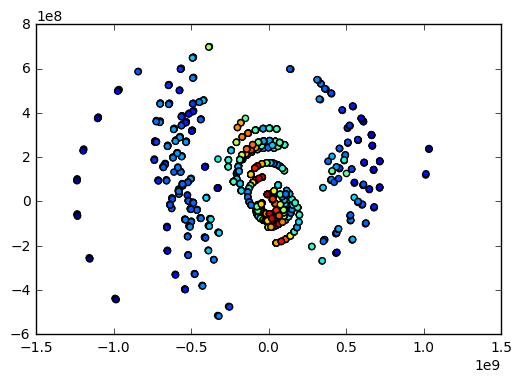

(2048, 2048)
(2048, 2048)


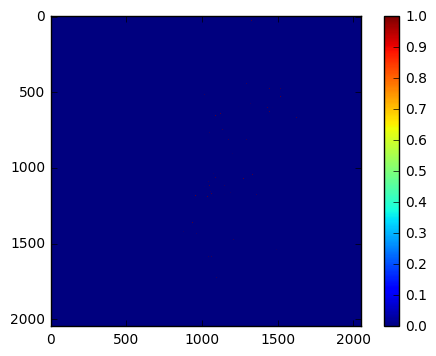

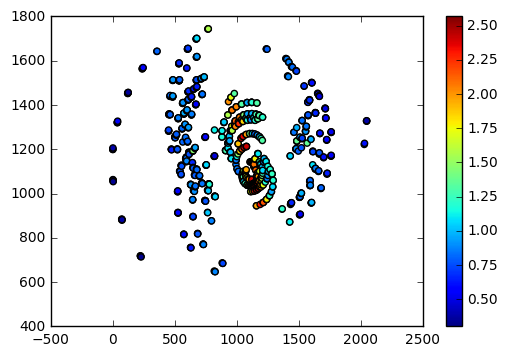

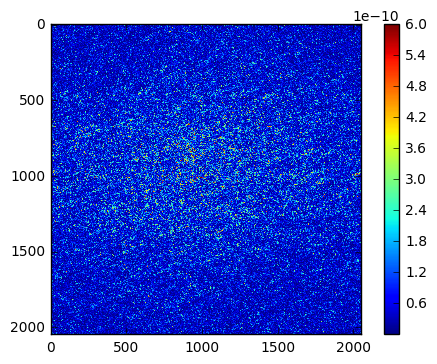

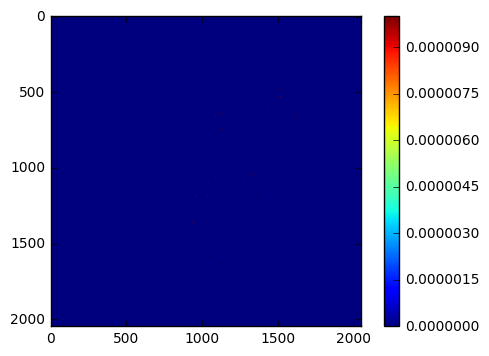

CLEAN Algorithm starts here:
(2048, 2048)
(2048, 2048)


In [44]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift

def F(mat2D): #Fourier Transform at zero
    mat2D = np.fft.fftshift(mat2D)
    mat2D = np.fft.fft2(mat2D)
    mat2D = np.fft.fftshift(mat2D)
    return mat2D

def Ft(mat2D): #Inverse Fourier Transform at zero
    mat2D = np.fft.fftshift(mat2D)
    mat2D = np.fft.ifft2(mat2D)
    mat2D = np.fft.fftshift(mat2D)
    return mat2D

#Load Boston University data

data = loadmat('3C111MAY14.mat')
u = data['u']
v = data['v']
amp = data['amp']
phase = data['phase']
print(data)
print(u)
print(v)
print(amp)
print(phase)
print(u.shape)
print(v.shape)
print(amp.shape)
print(phase.shape)

#Plot uv data
plt.figure()
plt.scatter(u, v, c=amp)

amp = np.squeeze(data['amp'])
phase = np.squeeze(data['phase'])

plt.show()

#Convert uv data to numpy matrix
num_points = 2**11
max_val = np.max([np.max(u), np.max(v)])
min_val = np.min([np.min(u), np.min(v)])

u_vec = np.linspace(min_val, max_val, num_points)

uv_mat = np.zeros([num_points, num_points], dtype=np.complex64) #Note the necessity of specifying the dtype
PSF = np.zeros([num_points, num_points], dtype=np.complex64)

for point in range(len(u)):
    #find closest point in uv_mat
    u_coord = np.argmin(np.abs(u_vec - u[point]))
    v_coord = np.argmin(np.abs(u_vec - v[point]))
    
    uv_mat[u_coord, v_coord] = amp[point]*np.exp(1j*phase[point])
    PSF[u_coord, v_coord] = 1.

print(uv_mat.shape)    
print(PSF.shape)    
plt.figure()
plt.imshow(np.abs(PSF)) #Abs necessary because PSF is complex
plt.colorbar()
plt.show()

plt.figure()
plt.scatter(np.nonzero(np.abs(PSF))[0], np.nonzero(np.abs(PSF))[1], c=np.abs(uv_mat[np.nonzero(np.abs(PSF))])) 
plt.colorbar()
plt.show()

PDF = Ft(PSF)
dirty_beam = Ft(uv_mat)

plt.figure()
plt.imshow(np.abs(dirty_beam)**2, vmax=0.6e-9)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.abs(PSF),vmax=1e-5)
plt.colorbar()
plt.show()

print("CLEAN Algorithm starts here:")

noise_floor = 0.5*np.max(np.abs(dirty_beam))
max_iter = 1e2
cleaned_img = np.zeros([num_points, num_points], dtype=np.complex64)

#While loop
max_inds = np.unravel_index(np.argmax(np.abs(dirty_beam)), dirty_beam.shape) #Find point with highest intensity
gain = dirty_beam[max_inds]/np.max(np.abs(PSF))
shifted_real = shift(np.real(PSF),[max_inds[0] - num_points//2, max_inds[1] - num_points//2])
shifted_imag = shift(np.imag(PSF), [max_inds[0] - num_points//2, max_inds[1] - num_points//2])
dirty_beam = dirty_beam - gain*(shifted_real + 1j*shifted_imag)
cleaned_img[max_inds] = gain

print(shifted_real.shape)
print(shifted_imag.shape)
            
#EXERCISE: Implement the while loop. Filter cleaned_img with gaussian kernel at end
